In [47]:
import cv2
import os
import glob
import tqdm
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import circmean

In [52]:
def split_array(arr, min_length=2):
    """
    Split a numpy array containing np.nans and floats into sub-arrays of only numbers.
    
    Parameters:
    arr (numpy.ndarray): Input array with a mix of np.nans and floats.
    min_length (int): Minimum length of each sub-array. Default is 2.
    
    Returns:
    list: List of numpy arrays, each containing only numbers and longer than min_length.
    """
    # Ensure the input is a numpy array
    arr = np.asarray(arr)
    
    # Find indices where the array is not NaN
    valid_indices = np.where(~np.isnan(arr))[0]
    
    # Find breaks in the sequence of valid indices
    breaks = np.where(np.diff(valid_indices) > 1)[0] + 1
    
    # Split the valid indices into groups
    index_groups = np.split(valid_indices, breaks)
    
    # Create sub-arrays and filter by minimum length
    result = [arr[group] for group in index_groups if len(group) >= min_length]
    
    return result


In [30]:
root_folder = "/home/buchsbaum/Desktop/20230626_pixel_to_direction_calibration_/"
video_files = glob.glob(os.path.join(root_folder, "*.mp4"))

In [40]:
data = {}
for vf in video_files:
    
    data[os.path.basename(vf)] = {}

    xs = []
    ys = []

    cap = cv2.VideoCapture(vf)
    while True:
        ret, frame = cap.read()
        cX = np.nan
        cY = np.nan

        if not ret:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)

        kernel = np.ones((15,15), np.uint8)
        dilated = cv2.dilate(thresh, kernel, iterations=1)

        contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) > 0:
            cv2.drawContours(frame, contours, -1, (0, 255, 0), 2)
            
            # get centroid
            M = cv2.moments(contours[0])
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
        
        xs.append(cX)
        ys.append(cY)

    data[os.path.basename(vf)]["x"] = xs
    data[os.path.basename(vf)]["y"] = ys


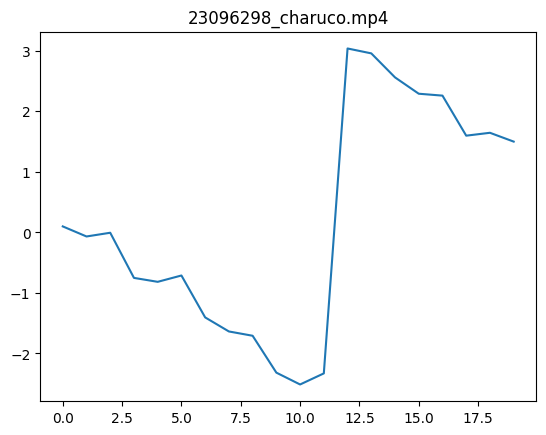

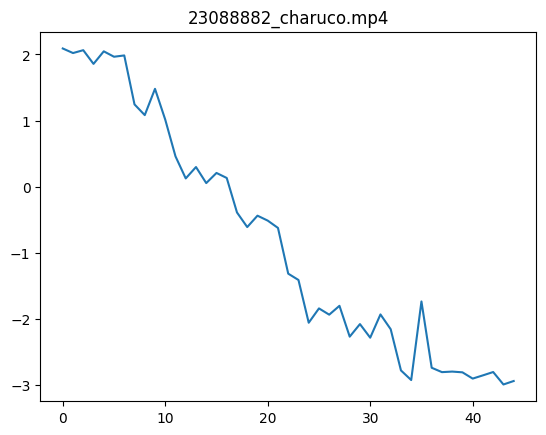

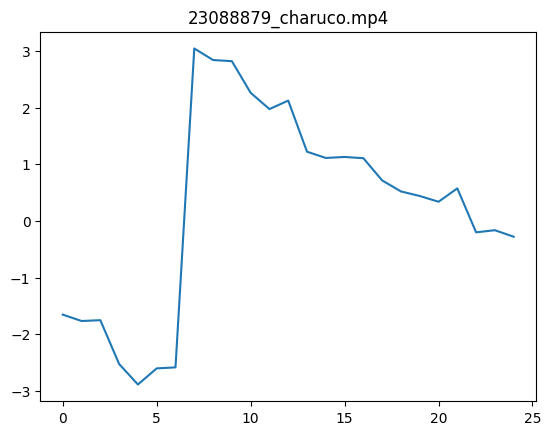

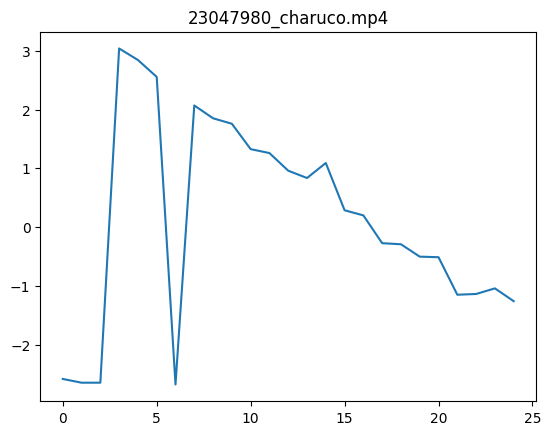

In [55]:
for k, v in data.items():
    
    x_arrays = split_array(v["x"], min_length=10)
    y_arrays = split_array(v["y"], min_length=10)

    # get heading
    headings = []
    for x, y in zip(x_arrays, y_arrays):
        heading = np.arctan2(y[-1] - y[0], x[-1] - x[0])
        headings.append(heading)


    plt.plot(headings)
    plt.title(k)
    plt.show()